In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, datasets, Model, Sequential, backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

Imagens:https://www.kaggle.com/datasets/andrewmvd/medical-mnist
Não foram utilizadas todas as imagens


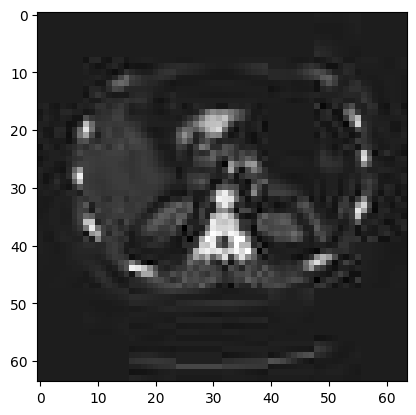

In [19]:
im = plt.imread('/content/images/abd/000000.jpeg')
plt.imshow(im, 'gray')

In [20]:
im.shape


(64, 64)

In [21]:
files = glob.glob('/content/images/**/*.jpeg', recursive=True)

In [22]:
len(files)

1806

In [23]:
df = pd.DataFrame({'path': files})

In [24]:
df.head()

,path
0,/content/images/head/000249.jpeg
1,/content/images/head/000223.jpeg
2,/content/images/head/000208.jpeg
3,/content/images/head/000104.jpeg
4,/content/images/head/000233.jpeg


In [25]:
df['class'] = df['path'].apply(lambda x: x.split('/')[3])

In [26]:
df['class'].value_counts()

head      301
breast    301
abd       301
cxr       301
hand      301
chest     301
Name: class, dtype: int64

In [27]:
df.head()

,path,class
0,/content/images/head/000249.jpeg,head
1,/content/images/head/000223.jpeg,head
2,/content/images/head/000208.jpeg,head
3,/content/images/head/000104.jpeg,head
4,/content/images/head/000233.jpeg,head


In [28]:
X = df['path']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [29]:
len(X_train)

1625

In [30]:
len(X_test)

181

In [31]:
BATCH_SIZE = 30

In [32]:
data_generator = ImageDataGenerator(rotation_range=20, rescale=1./255, validation_split=0.15)

In [33]:
df_train = pd.concat([X_train, y_train], axis=1)

In [34]:
df_train.head()

,path,class
1209,/content/images/hand/000260.jpeg,hand
773,/content/images/abd/000043.jpeg,abd
126,/content/images/head/000135.jpeg,head
1794,/content/images/chest/000274.jpeg,chest
1063,/content/images/cxr/000267.jpeg,cxr


In [35]:
train_generator = data_generator.flow_from_dataframe(dataframe=df_train,
                                                     x_col='path',
                                                     y_col='class',
                                                     target_size=(64,64),
                                                     color_mode='grayscale',
                                                     batch_size=BATCH_SIZE,
                                                     subset='training')

Found 1382 validated image filenames belonging to 6 classes.


In [36]:
valid_generator = data_generator.flow_from_dataframe(dataframe=df_train,
                                                     x_col='path',
                                                     y_col='class',
                                                     target_size=(64,64),
                                                     color_mode='grayscale',
                                                     batch_size=BATCH_SIZE,
                                                     subset='validation')

Found 243 validated image filenames belonging to 6 classes.


In [37]:
def build_model():
    model = Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=2, activation='relu', input_shape=(64,64,1)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(28, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    return model

In [38]:
model = build_model()

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 28)                861084    
                                                                 
 dense_3 (Dense)             (None, 6)                 174       
                                                      

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
checkpoint = ModelCheckpoint('medical_image.hdf5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

In [42]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min' )

In [43]:
model.fit(train_generator,
          callbacks=[checkpoint, early_stop],
          steps_per_epoch=train_generator.samples//BATCH_SIZE,
          validation_data=valid_generator,
          validation_steps=valid_generator.samples//BATCH_SIZE,
          epochs=50)

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 1.0406 - accuracy: 0.5459
Epoch 1: val_loss improved from inf to 0.52218, saving model to medical_image.hdf5
46/46 [==============================] - 7s 124ms/step - loss: 1.0406 - accuracy: 0.5459 - val_loss: 0.5222 - val_accuracy: 0.8333
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8794
Epoch 2: val_loss improved from 0.52218 to 0.25162, saving model to medical_image.hdf5
46/46 [==============================] - 7s 146ms/step - loss: 0.3916 - accuracy: 0.8794 - val_loss: 0.2516 - val_accuracy: 0.9542
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9453
Epoch 3: val_loss improved from 0.25162 to 0.09489, saving model to medical_image.hdf5
46/46 [==============================] - 6s 135ms/step - loss: 0.1627 - accuracy: 0.9453 - val_loss: 0.0949 - val_accuracy: 0.9833
Epoch 4/50
46/46 [==============================] - ETA: 0s - loss: 

In [44]:
model = load_model('medical_image.hdf5')

In [46]:
test_imgs=[img_to_array(load_img(im_path, grayscale=True)) for im_path in X_test]

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [47]:
y_pred = model.predict(np.array(test_imgs))

6/6 [==============================] - 0s 21ms/step


In [48]:
y_pred.argmax(axis=1)

array([2, 0, 2, 4, 2, 4, 3, 2, 2, 2, 0, 0, 0, 4, 0, 3, 3, 2, 2, 2, 4, 2,
       2, 4, 2, 0, 2, 0, 2, 4, 4, 4, 3, 2, 2, 0, 0, 4, 3, 2, 3, 2, 2, 4,
       3, 2, 2, 2, 3, 0, 2, 2, 3, 4, 3, 4, 2, 2, 4, 2, 4, 2, 0, 2, 2, 3,
       2, 2, 2, 2, 2, 4, 2, 2, 4, 3, 0, 2, 4, 3, 0, 3, 0, 4, 4, 2, 0, 2,
       3, 3, 0, 4, 3, 2, 2, 2, 3, 3, 4, 2, 2, 3, 2, 2, 4, 4, 2, 2, 0, 0,
       4, 3, 2, 4, 2, 2, 0, 4, 0, 2, 2, 4, 4, 2, 4, 2, 2, 2, 3, 3, 2, 0,
       4, 2, 0, 2, 0, 4, 4, 2, 3, 3, 2, 0, 2, 2, 4, 2, 2, 2, 2, 2, 3, 4,
       3, 0, 2, 2, 3, 4, 2, 4, 2, 3, 4, 0, 4, 3, 2, 2, 2, 2, 2, 2, 3, 2,
       4, 2, 2, 2, 2])

In [65]:
train_generator = data_generator.flow_from_dataframe(dataframe=df_train,
                                                     x_col='path',
                                                     y_col='class',
                                                     class_mode='categorical',
                                                     target_size=(64,64),
                                                     color_mode='rgb',
                                                     batch_size=BATCH_SIZE,
                                                     subset='training')

Found 1382 validated image filenames belonging to 6 classes.


In [67]:
valid_generator = data_generator.flow_from_dataframe(dataframe=df_train,
                                                     x_col='path',
                                                     y_col='class',
                                                     class_mode='categorical',
                                                     target_size=(64,64),
                                                     color_mode='rgb',
                                                     batch_size=BATCH_SIZE,
                                                     subset='validation')

Found 243 validated image filenames belonging to 6 classes.


In [75]:
def build_model2(shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=shape)
    for layer in base_model.layers[:3]:
        layer.Trainable= False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    prediction = layers.Dense(6, activation='softmax')(x)
    model = Model(base_model.input, prediction)
    return model

In [76]:
model = build_model2((64,64,3))

In [77]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [78]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(train_generator,
          callbacks=[checkpoint, early_stop],
          steps_per_epoch=train_generator.samples//BATCH_SIZE,
          validation_data=valid_generator,
          validation_steps=valid_generator.samples//BATCH_SIZE,
          epochs=50)

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9326
Epoch 1: val_loss did not improve from 0.00642
46/46 [==============================] - 49s 725ms/step - loss: 0.2450 - accuracy: 0.9326 - val_loss: 9.3220 - val_accuracy: 0.5250
Epoch 2/50
28/46 [=================>............] - ETA: 11s - loss: 0.0921 - accuracy: 0.9803